# Modelling Ames housing data to predict prices

### Imports

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

from sklearn.linear_model import Lasso, LassoCV, LinearRegression, Ridge, RANSACRegressor


from sklearn_pandas import CategoricalImputer
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures, LabelBinarizer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier

# make life easier
pd.set_option('display.max_rows', None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.base import TransformerMixin

class SafeLabelBinarizer(TransformerMixin):

    def __init__(self):
        self.lb = LabelBinarizer()

    def fit(self, X):
        X = np.array(X)
        self.lb.fit(X)
        self.classes_ = self.lb.classes_

    def transform(self, X):
        K = np.append(self.classes_, ['__FAKE__'])
        X = label_binarize(X, K, pos_label=1, neg_label=0)
        X = np.delete(X, np.s_[-1], axis=1)
        return X
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

### Load data

load data into pdf, only mark missing values as NaN.

In [2]:
df = pd.read_csv('data/train.csv', na_values = '', keep_default_na = False)

### Clean data

drop outliers

In [3]:
df = df.drop(df[df['Gr Liv Area'] > 4000].index)

find columns with NaN values

In [4]:
na_df = pd.DataFrame(df.isna().sum(), columns = ['na_values'])
nz = na_df['na_values'].to_numpy().nonzero()
na_df.iloc[nz]

,na_values
Lot Frontage,330
Mas Vnr Type,22
Mas Vnr Area,22
Bsmt Qual,1
Bsmt Cond,1
Bsmt Exposure,4
BsmtFin Type 1,1
BsmtFin SF 1,1
BsmtFin Type 2,2
BsmtFin SF 2,1


drop NaN values from columns with few NaN values

In [5]:
df = df.dropna(subset=['Bsmt Qual','Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF','Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond'])

In [6]:
na_df = pd.DataFrame(df.isna().sum(), columns = ['na_values'])
nz = na_df['na_values'].to_numpy().nonzero()
na_df.iloc[nz]

,na_values
Lot Frontage,330
Mas Vnr Type,22
Mas Vnr Area,22
Garage Yr Blt,113


### Train_test split

In [7]:
target = 'SalePrice'
y = df[target]
X = df.drop([target], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Dataframe mapper

Dataframe mapper to impute missing values, labelbinarize nominal values, ordinal encode ordinal values, label encode binary values and standard scale continuous values

In [8]:
mapper = DataFrameMapper([
    ('MS SubClass', SafeLabelBinarizer()),
    ('MS Zoning', SafeLabelBinarizer()),
    (['Lot Frontage'], [SimpleImputer(strategy = 'constant', fill_value = 0), StandardScaler()]),
    (['Lot Area'], StandardScaler()),
    ('Street', SafeLabelBinarizer()),
    ('Alley', SafeLabelBinarizer()),
    (['Lot Shape'], OrdinalEncoder(categories = [['Reg', 'IR1', 'IR2', 'IR3']])),
    (['Land Contour'], OrdinalEncoder(categories = [['Lvl', 'Low', 'Bnk', 'HLS']])),
    (['Utilities'], SafeLabelBinarizer()),
    ('Lot Config', SafeLabelBinarizer()),
    (['Land Slope'], OrdinalEncoder(categories = [['Gtl', 'Mod', 'Sev']])),
    ('Neighborhood', SafeLabelBinarizer()),
    ('Condition 1', SafeLabelBinarizer()),
    ('Condition 2', SafeLabelBinarizer()),
    ('Bldg Type', SafeLabelBinarizer()),
    ('House Style', SafeLabelBinarizer()),
    (['Overall Qual'], OrdinalEncoder(categories = [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])),
    (['Overall Cond'], OrdinalEncoder(categories = [[1, 2, 3, 4, 5, 6, 7, 8, 9]])),
    (['Year Built'], None),
    (['Year Remod/Add'], None),
    ('Roof Style', SafeLabelBinarizer()),
    ('Roof Matl', SafeLabelBinarizer()),
    ('Exterior 1st', SafeLabelBinarizer()),
    ('Exterior 2nd', SafeLabelBinarizer()),
    (['Mas Vnr Type'], [SimpleImputer(strategy = 'constant', fill_value = 'Not_applicable'), SafeLabelBinarizer()]),
    (['Mas Vnr Area'], [SimpleImputer(strategy = 'constant', fill_value = 0), StandardScaler()]),
    (['Exter Qual'], OrdinalEncoder(categories = [['Ex', 'Gd', 'TA', 'Fa']])),
    (['Exter Cond'], OrdinalEncoder(categories = [['Ex', 'Gd', 'TA', 'Fa', 'Po']])),
    ('Foundation', SafeLabelBinarizer()),
    (['Bsmt Qual'], SafeLabelBinarizer()),
    (['Bsmt Cond'], OrdinalEncoder(categories = [['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']])),
    (['Bsmt Exposure'], OrdinalEncoder(categories = [['NA', 'No', 'Mn', 'Av', 'Gd']])),
    (['BsmtFin Type 1'], OrdinalEncoder(categories = [['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ','GLQ']])),
    (['BsmtFin SF 1'], StandardScaler()),
    (['BsmtFin Type 2'], [SimpleImputer(strategy = 'constant', fill_value = 'Not_applicable'), OrdinalEncoder(categories = [['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ','GLQ']])]),
    (['BsmtFin SF 2'], StandardScaler()),
    (['Bsmt Unf SF'], StandardScaler()),
    (['Total Bsmt SF'], StandardScaler()),
    (['Heating'], SafeLabelBinarizer()),
    (['Heating QC'], OrdinalEncoder(categories = [['Ex', 'Gd', 'TA', 'Fa', 'Po']])),
    ('Central Air', LabelEncoder()),
    (['Electrical'], OrdinalEncoder(categories = [['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix']])),
    (['1st Flr SF'], StandardScaler()),
    (['2nd Flr SF'], StandardScaler()),
    (['Low Qual Fin SF'], StandardScaler()),
    (['Gr Liv Area'], StandardScaler()),
    ('Bsmt Full Bath', None),
    ('Bsmt Half Bath', None),
    ('Full Bath', None),
    ('Half Bath', None),
    ('Bedroom AbvGr', None),
    ('Kitchen AbvGr', None),
    (['Kitchen Qual'], OrdinalEncoder(categories = [['Fa', 'TA', 'Gd', 'Ex']])),
    ('TotRms AbvGrd', None),
    (['Functional'], SafeLabelBinarizer()),
    ('Fireplaces', None),
    (['Fireplace Qu'], OrdinalEncoder(categories = [['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])),
    ('Garage Type', SafeLabelBinarizer()),
    (['Garage Yr Blt'], [SimpleImputer(strategy = 'constant', fill_value = 0), StandardScaler()]),
    (['Garage Finish'], OrdinalEncoder(categories = [['NA', 'Unf', 'RFn', 'Fin']])),
    ('Garage Cars', None),
    (['Garage Area'], StandardScaler()),
    (['Garage Qual'], OrdinalEncoder(categories = [['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']])),
    (['Garage Cond'], OrdinalEncoder(categories = [['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']])),
    (['Paved Drive'], OrdinalEncoder(categories = [['Y', 'P', 'N']])),
    (['Wood Deck SF'], StandardScaler()),
    (['Open Porch SF'], StandardScaler()),
    (['Enclosed Porch'], StandardScaler()),
    (['3Ssn Porch'], StandardScaler()),
    (['Screen Porch'], StandardScaler()),
    (['Pool Area'], StandardScaler()),
    (['Pool QC'], OrdinalEncoder(categories = [['NA', 'Fa', 'TA', 'Gd', 'Ex']])),
    (['Fence'], OrdinalEncoder(categories = [['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']])),
    (['Misc Feature'], SafeLabelBinarizer()),
    (['Misc Val'], StandardScaler()),
    ('Mo Sold', None),
    ('Yr Sold', None),
    ('Sale Type', SafeLabelBinarizer())], df_out = True)

### Naive model

House prices go up as the number of rooms increase. 

In [9]:
linreg = LinearRegression()
linreg.fit(X_train[['Bedroom AbvGr']], y_train)
linreg.score(X_test[['Bedroom AbvGr']], y_test)

0.007158416954324398

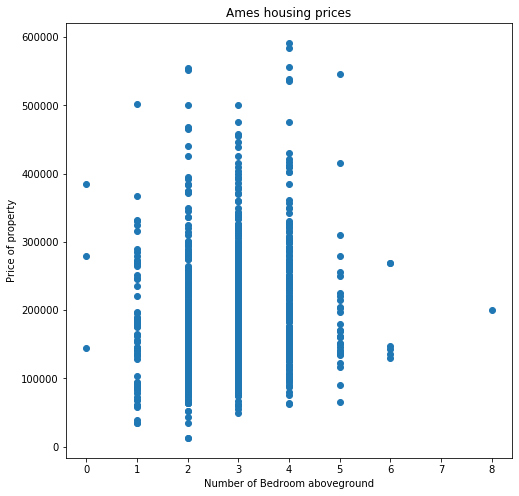

In [10]:
plt.figure(figsize = (8,8))
plt.scatter(X_train[['Bedroom AbvGr']], y_train)
plt.xlabel('Number of Bedroom aboveground')
plt.ylabel('Price of property')
plt.title('Ames housing prices');

It seems that the number of bedrooms can only predict the pricing of a house with 0.7% accuracy.  

### Exploratory analysis

Transfrom train data with mapper.

In [11]:
Z_train = mapper.fit_transform(X_train)

Scatter plots to see relationship of features with y. The same result can be achieved through pairplot in seaborn, but doing it through a for loop allowed me to have clearer figures in reasonable sizes.

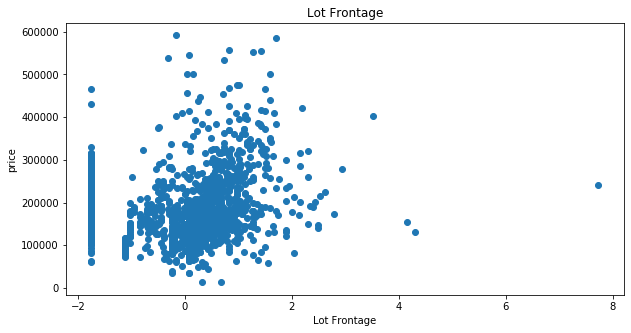

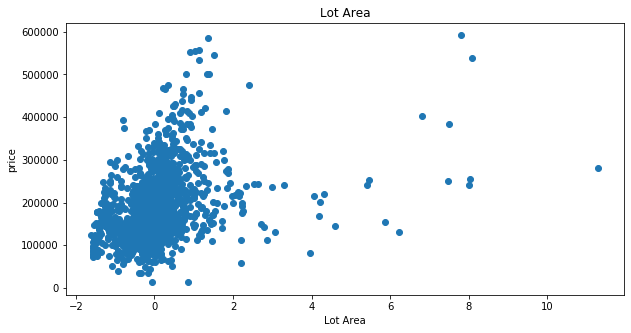

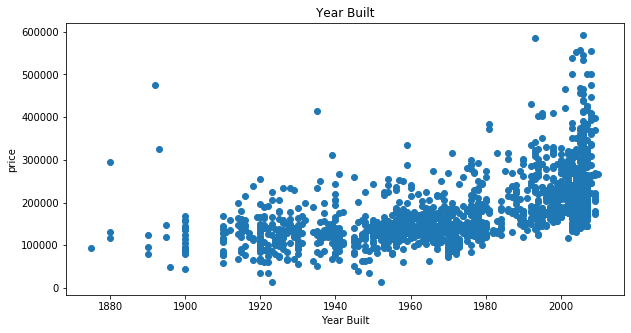

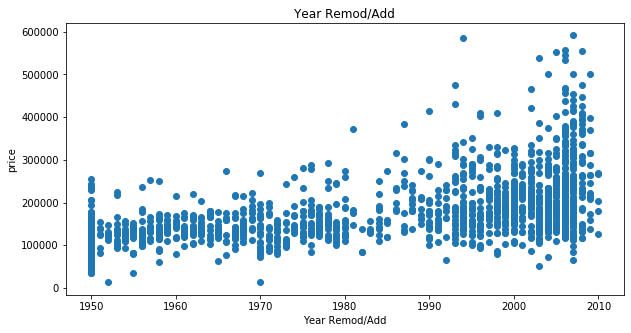

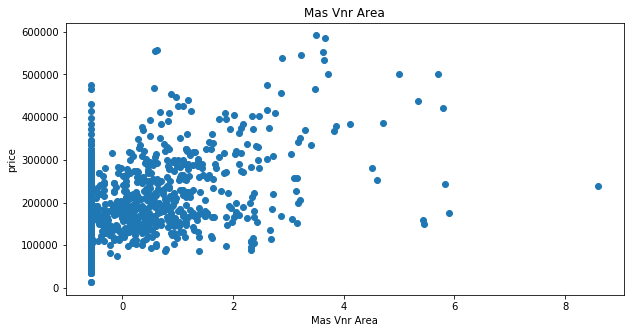

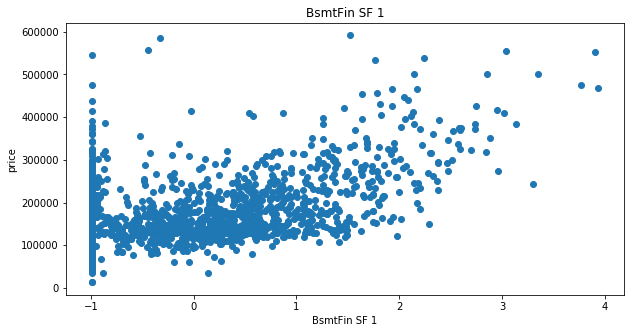

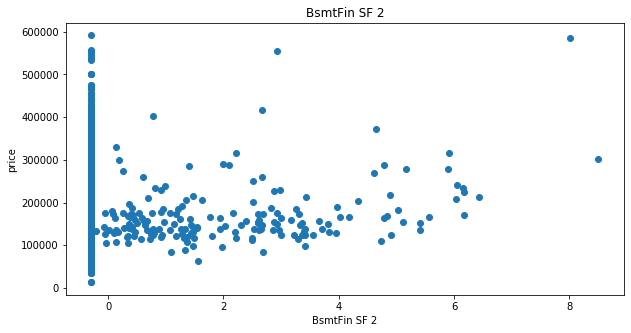

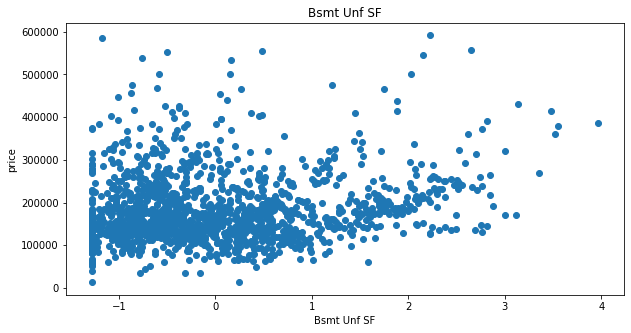

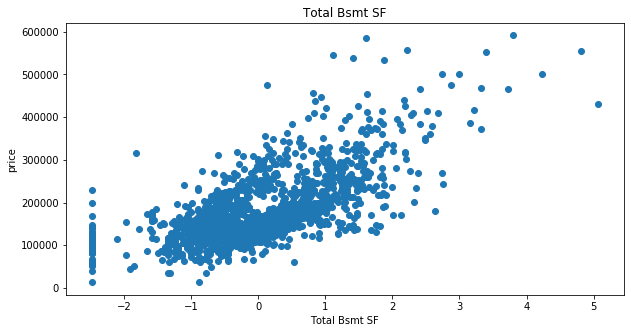

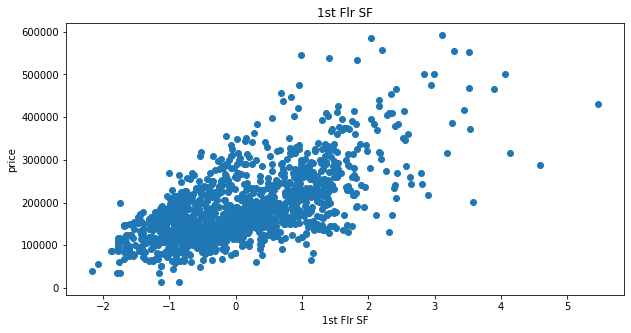

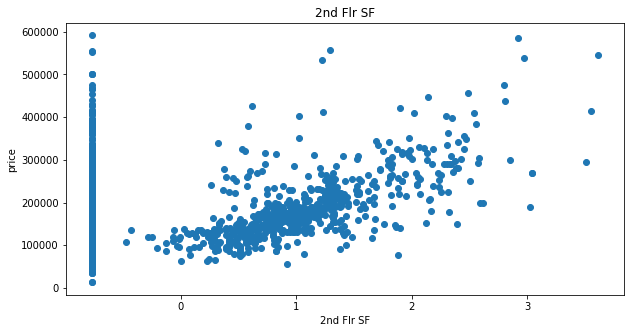

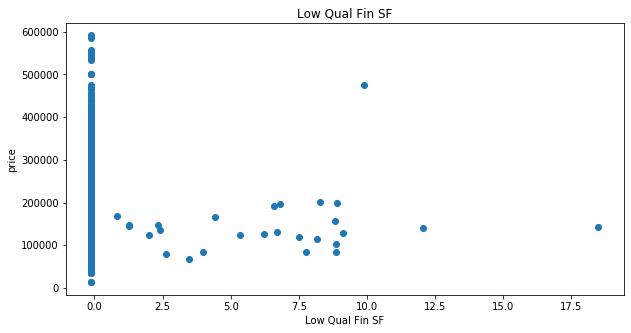

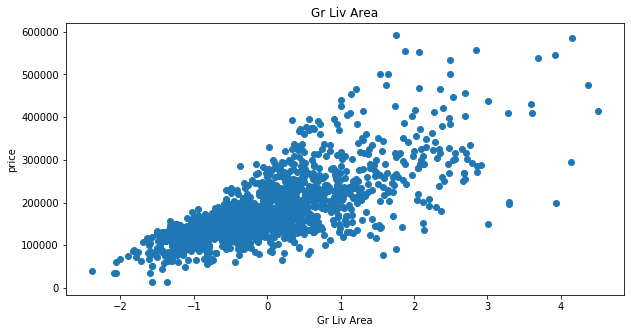

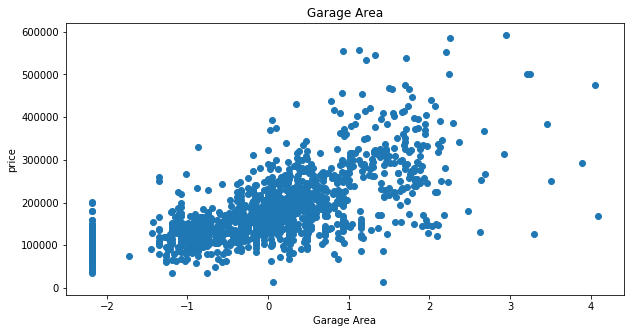

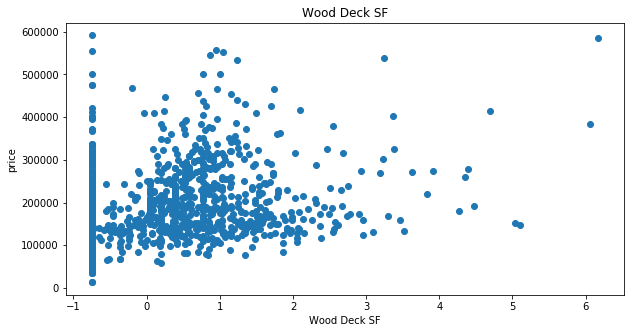

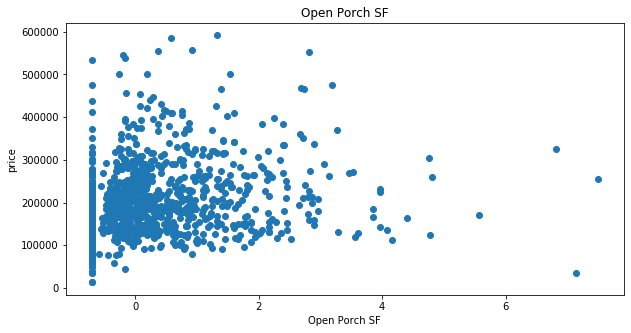

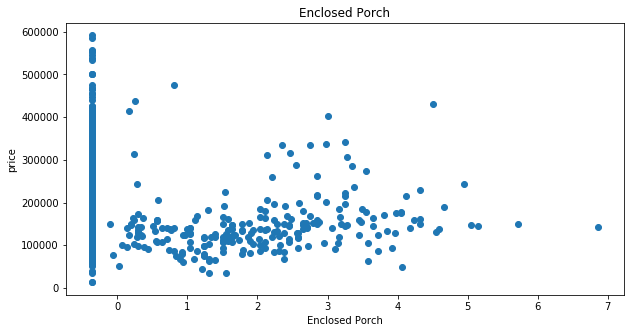

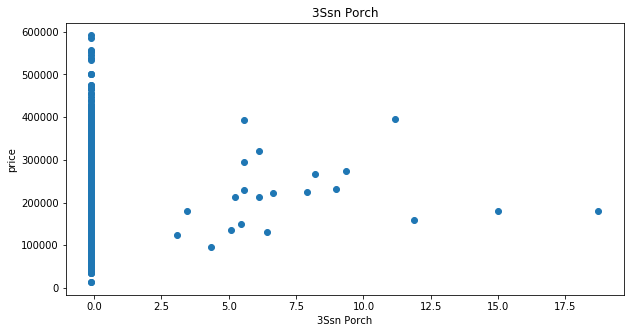

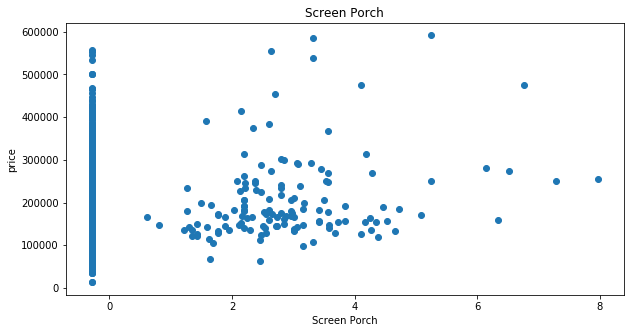

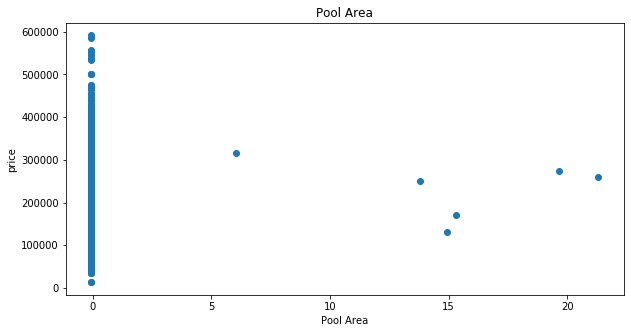

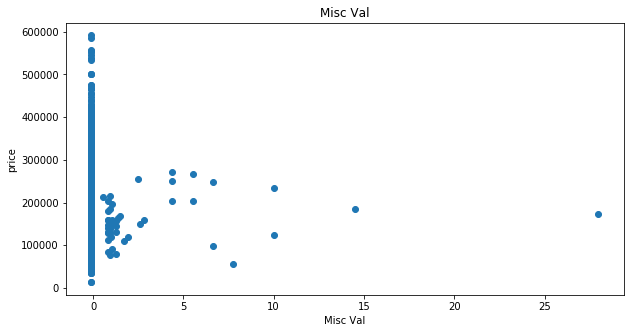

In [12]:
continuous = ['Lot Frontage', 'Lot Area', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val']
for feature in continuous:
    plt.figure(figsize = (10,5))
    plt.scatter(Z_train[feature], y_train)
    plt.ylabel('price')
    plt.xlabel(feature)
    plt.title(feature)
    plt.show()

From the scatter plots Lot frontage, lot area, year built, total bsmt SF, gr living area and garage area seem to be correlated with the price.

### Feature selection through RFE

In [13]:
from sklearn.feature_selection import RFE

select = RFE(RandomForestClassifier(n_estimators=10, random_state=42), n_features_to_select=10)
select.fit(Z_train, y_train)
Z_train_selected = select.transform(Z_train)

Put selected columns in a df to see.

In [14]:
selection = select.get_support()
select_df = pd.DataFrame(zip(Z_train.columns.ravel(), selection), columns = ['feature', 'bool'])
select_df[select_df['bool']]

,feature,bool
24,Lot Area,True
99,Year Built,True
163,BsmtFin SF 1,True
166,Bsmt Unf SF,True
167,Total Bsmt SF,True
176,1st Flr SF,True
179,Gr Liv Area,True
204,Garage Yr Blt,True
207,Garage Area,True
225,Mo Sold,True


See how our model was doing without the selected columns:

In [15]:
linreg.fit(Z_train, y_train)
linreg.score(Z_train, y_train)

0.9402831425623859

See how it is doing after feature selection

In [16]:
linreg.fit(Z_train_selected, y_train)
linreg.score(Z_train_selected, y_train)

0.8041537657575873

### Try different models

#### Linreg:

In [17]:
linreg.fit(Z_train_selected, y_train)
linreg.score(Z_train_selected, y_train)

0.8041537657575873

#### Lasso:

In [18]:
lassomodel = Lasso()
lassomodel.fit(Z_train_selected, y_train)
lassomodel.score(Z_train_selected, y_train)

0.8041537609180501

#### Ridge:

In [19]:
ridgemodel = Ridge()
ridgemodel.fit(Z_train_selected, y_train)
ridgemodel.score(Z_train_selected, y_train)

0.8041534321047469

#### RANSAC:

In [20]:
rsmodel = RANSACRegressor()
rsmodel.fit(Z_train_selected, y_train)
rsmodel.score(Z_train_selected, y_train)

0.7748606219972884

### Evaluation

Try out a few metrics on these models to see how they measure (Do not fit or fit_transform Z_test, only transform).

In [21]:
Z_test = mapper.transform(X_test)
Z_test_selected = select.transform(Z_test)


linreg_pred = linreg.predict(Z_test_selected)
lasso_pred = lassomodel.predict(Z_test_selected)
ridge_pred = ridgemodel.predict(Z_test_selected)
rs_pred = rsmodel.predict(Z_test_selected)
metrics_df = pd.DataFrame([
    ('linreg', r2_score(linreg_pred, y_test), mean_squared_error(linreg_pred, y_test), mean_absolute_error(linreg_pred, y_test)),
    ('lasso', r2_score(lasso_pred, y_test), mean_squared_error(lasso_pred, y_test), mean_absolute_error(lasso_pred, y_test)),
    ('ridge', r2_score(ridge_pred, y_test), mean_squared_error(ridge_pred, y_test), mean_absolute_error(ridge_pred, y_test)),
    ('RANSAC', r2_score(rs_pred, y_test), mean_squared_error(rs_pred, y_test), mean_absolute_error(rs_pred, y_test))
], columns = ['score', 'r2 score', 'mean squared error', 'mean absolute error'])
metrics_df

,score,r2 score,mean squared error,mean absolute error
0,linreg,0.695536,1.529074e+09,26749.600252
1,lasso,0.695534,1.529023e+09,26748.818246
2,ridge,0.695444,1.528708e+09,26742.650040
3,RANSAC,0.628390,1.678275e+09,27572.785348


Since linreg, lasso and ridge are showing simmilar scores and errors, any one of the three should work. I will pick Lasso in this case because we are dealing with a lot of features in this dataset and lasso can help minimize unimportant features.

### Pipeline

Make pipeline for new data

In [24]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(mapper, select, lassomodel)
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7651994737908446

### Conclusion and recommendation

Housing prices can be predicted with 76.5% accuracy through this model.

- Agricultural zones,
- industrial zones,
- all public utilities(electricity, gas, water),
- proximity to north-south railroad,
- overall quality,
- imitation stucco on the exterior,
- stone foundation,
- salavge only properties,
- miscellenious features,
- 15% down payment contract payment option on sale or
- just contracted homes

are the factors affecting sale prices in this dataset.

In [25]:
alt.renderers.enable('notebook')
final_feature_df = select_df[select_df['bool']]
final_features = list(set(final_feature_df.feature.tolist()) - {'Garage Yr Blt', 'Mo Sold'})
alt_df = pd.DataFrame(Z_train_selected, columns = final_feature_df.feature.tolist())
alt_df['y'] = 0
alt_df['y'] = y_train.values
charts = []
colors = ['purple', 'darkblue', 'skyblue', 'limegreen', 'gold', 'orangered', 'red', 'pink']

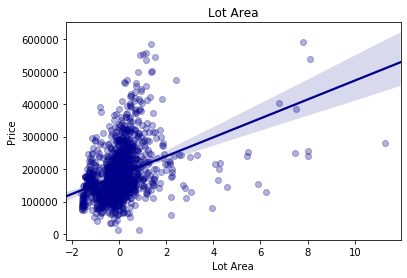

In [26]:
sns.regplot(alt_df[final_features[1]], alt_df['y'], color = colors[1], scatter_kws={'alpha':0.3})
plt.ylabel('Price')
plt.title(final_features[1]);

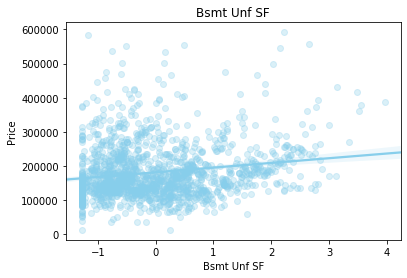

In [27]:
sns.regplot(alt_df[final_features[2]], alt_df['y'], color = colors[2], scatter_kws={'alpha':0.3})
plt.ylabel('Price')
plt.title(final_features[2]);

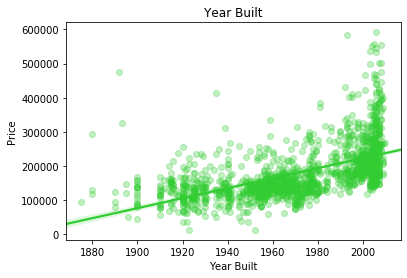

In [28]:
sns.regplot(alt_df[final_features[3]], alt_df['y'], color = colors[3], scatter_kws={'alpha':0.3})
plt.ylabel('Price')
plt.title(final_features[3]);

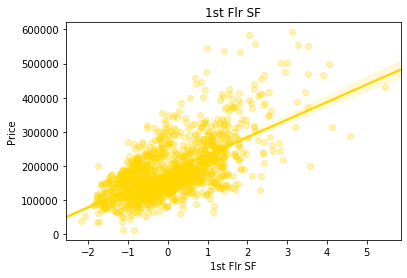

In [29]:
sns.regplot(alt_df[final_features[4]], alt_df['y'], color = colors[4], scatter_kws={'alpha':0.3})
plt.ylabel('Price')
plt.title(final_features[4]);

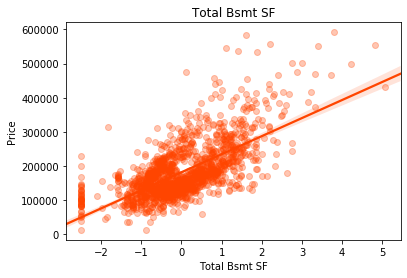

In [30]:
sns.regplot(alt_df[final_features[5]], alt_df['y'], color = colors[5], scatter_kws={'alpha':0.3})
plt.ylabel('Price')
plt.title(final_features[5]);

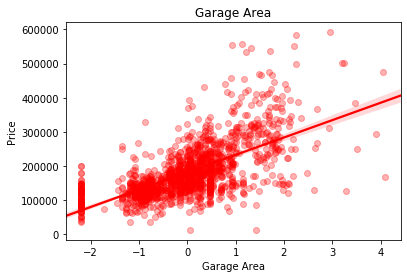

In [31]:
sns.regplot(alt_df[final_features[6]], alt_df['y'], color = colors[6], scatter_kws={'alpha':0.3})
plt.ylabel('Price')
plt.title(final_features[6]);